In [52]:
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2
%pylab inline
# %pylab notebook
# %load_ext wurlitzer
# standard imports
import matplotlib.pyplot as plt

import time
import numpy as np
from collections import namedtuple
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# drake + externals imports
from director import viewerclient as vc
from irispy import Polyhedron
import pydrake.solvers.mathematicalprogram as mathematicalprogram

# boxatlas
import boxatlas.boxatlas as box
from boxatlas.contactstabilization import BoxAtlasContactStabilization
from boxatlas.contactstabilizationutils import ContactStabilizationUtils as CSU
from utils.polynomial import Polynomial
from utils.piecewise import Piecewise
from boxatlas.boxatlascontroller import BoxAtlasController
from boxatlas.contactstabilizationutils import BoxAtlasDefaults

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [113]:
# construct a visualizer object
vis = vc.Visualizer()
vis.delete()

def solve_opt_problem(options, initial_state=None, visualize=True):
    controller = BoxAtlasController()
    robot = controller.robot
    
    if initial_state is None:
        initial_state = CSU.make_default_initial_state(robot)
        initial_state.vcom[0] = -1.75 # set initial velocity of com
        initial_state.contact_indicator = np.array([0,1,1,0], dtype=int)

    num_time_steps = 20
    T = 1.0
    dt = T/num_time_steps
    print("dt = ", dt)

    # make contact assignments
    constrained_limbs = dict()

    if False:
        constrained_limbs["right_leg"] = 1  # persistent contact
        constrained_limbs["left_leg"] = 1  # persistent contact
        constrained_limbs["right_arm"] = 0  # no contact



    contact_assignments = CSU.make_contact_assignment(dt, num_time_steps, constrained_limbs)

    opt = controller.construct_contact_stabilization_optimization(initial_state,
                                                                 num_time_steps=num_time_steps,
                                                                 dt=dt,
                                                                options=options,
                                                                 contact_assignments=contact_assignments)
    
    solnData = opt.solve()
    
    if visualize:
        vis.delete()
        box.planPlayback(vis, solnData, slider=True)
        print("solution took = ", solnData.solve_time)
        CSU.plot_contact_indicator(solnData)
    
    
    print("solution took = ", solnData.solve_time)
    return solnData


def runtime_analysis(solver_type, com_vel):
    print("\n\n solver_type = ", solver_type)
    assert solver_type in ["normal", "lambda"]
    
    options = dict()
    if solver_type == "normal":
        options['use_lambda_contact_formulation'] = False
    
    if solver_type == "lambda":
        options['use_lambda_contact_formulation'] = True
    
    controller = BoxAtlasController()
    robot = controller.robot
    initial_state = CSU.make_default_initial_state(robot)
    initial_state.contact_indicator = np.array([0,1,1,0], dtype=int)
    
    solve_time = range(len(com_vel))
    for idx, v in enumerate(com_vel):
        print("\n com_vel = ", v)
        initial_state.vcom[0] = v
        solnData = solve_opt_problem(options, initial_state=initial_state,
                                    visualize=False)
        
        solve_time[idx] = solnData.solve_time
    
    return solve_time
    

def runtime_comparison():
    com_vel = [-1.0, -1.5, -1.75]
#     com_vel = [-1.75]
    
    solver_list = ["normal", "lambda"]
    d = dict()
    for solver in solver_list:
        d[solver] = runtime_analysis(solver, com_vel)
        
    returnDict = dict()
    returnDict['times'] = d
    returnDict['com_vel'] = com_vel
    return returnDict

def make_bar_chart(data):
    com_vel = np.array( data['com_vel'])
    times = data['times']
    
    fig, ax = plt.subplots()
    
    num_solvers = len(times)
    N = len(com_vel)
    x_base = np.array(range(0,N))
    width = 1
    delta_width = width*1.0/(num_solvers+1)
    for idx, solver in enumerate(times):
        x = x_base + delta_width*idx
        print(x)
        ax.bar(x, times[solver], delta_width, label=solver)
        
        
    # make the xtick labels
    x_labels = []
    for v in com_vel:
        x_labels.append(str(v))
        
    ax.set_xticks(x_base)
    ax.set_xticklabels(x_labels)

    plt.xlabel('initial com x-velocity')
    plt.ylabel('solve time')
    plt.legend()
    plt.show()
        
    
    
    
    



 solver_type =  normal

 com_vel =  -1.0
dt =  0.05
contact assignments passed in
solution took =  0.451463937759

 com_vel =  -1.5
dt =  0.05
contact assignments passed in
solution took =  1.58671998978

 com_vel =  -1.75
dt =  0.05
contact assignments passed in
solution took =  0.826800107956


 solver_type =  lambda

 com_vel =  -1.0
dt =  0.05
contact assignments passed in
using lambda contact formulation
solution took =  5.91137313843

 com_vel =  -1.5
dt =  0.05
contact assignments passed in
using lambda contact formulation
solution took =  2.43190312386

 com_vel =  -1.75
dt =  0.05
contact assignments passed in
using lambda contact formulation
solution took =  1.88045501709
[ 0.  1.  2.]
[ 0.33333333  1.33333333  2.33333333]


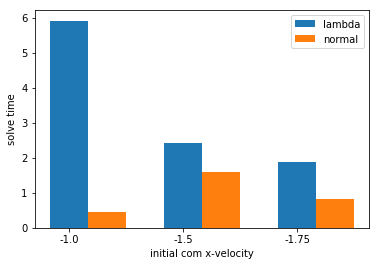

[ 0.  1.  2.]
[ 0.33333333  1.33333333  2.33333333]


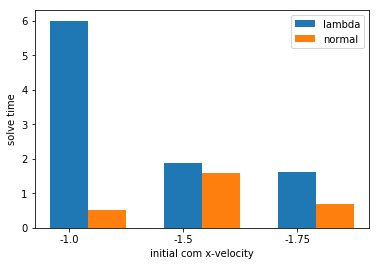

In [115]:
make_bar_chart(data)
a = [1,2,3]


# Standard Formulation

dt =  0.05
contact assignments passed in


solution took =  0.690792798996


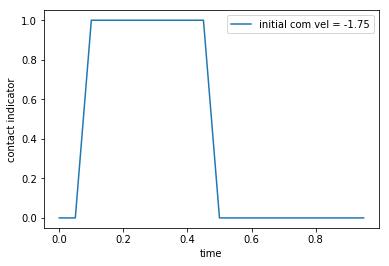

In [108]:
options = dict()
options['use_lambda_contact_formulation'] = False
solnData = solve_opt_problem(options)

# Lambda Formulation

dt =  0.05
contact assignments passed in
using lambda contact formulation


solution took =  7.0124361515


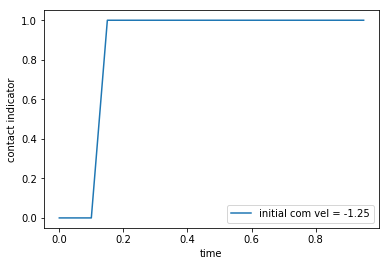

In [33]:
options = dict()
options['use_lambda_contact_formulation'] = True
solnData = solve_opt_problem(options)

# Compare Perfomance of Normal and Lambda Formulations



 solver_type =  normal

 com_vel =  -1.0
dt =  0.05
contact assignments passed in
solution took =  0.529255151749

 com_vel =  -1.5
dt =  0.05
contact assignments passed in
solution took =  1.58687400818

 com_vel =  -1.75
dt =  0.05
contact assignments passed in
solution took =  0.729478120804


 solver_type =  lambda

 com_vel =  -1.0
dt =  0.05
contact assignments passed in
using lambda contact formulation
solution took =  5.06714820862

 com_vel =  -1.5
dt =  0.05
contact assignments passed in
using lambda contact formulation
solution took =  1.97896003723

 com_vel =  -1.75
dt =  0.05
contact assignments passed in
using lambda contact formulation
solution took =  1.92444705963
[ 0.  1.  2.]
[ 0.33333333  1.33333333  2.33333333]


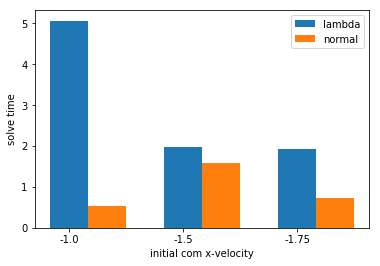

In [118]:
data = runtime_comparison()
make_bar_chart(data)

# Uncertainty about wall location

In [ ]:
# create visualization of this
def draw_surface(surface, name, color):
    verts2d = surface.pose_constraints.generatorPoints()
    assert len(verts2d) == 2
    length = np.linalg.norm(verts2d[1] - verts2d[0])
    origin = 0.5 * (verts2d[0] + verts2d[1])
    origin = [origin[0], 0, origin[1]]
    box =vc.GeometryData(vc.Box(lengths=[length, length, 0.01]), color=color)
    v = vis["test"][name]
    v.setgeometry(box)
    angle = np.arctan2(verts2d[1][1] - verts2d[0][1],
                       verts2d[1][0] - verts2d[0][0])
    v.settransform(vc.transformations.rotation_matrix(angle, [0, 1, 0],origin).dot(vc.transformations.translation_matrix(origin)))

    

def make_left_wall(dist_to_wall, height=2):
    mu_wall = 0.5
    left_wall_surface = box.Surface(Polyhedron.fromBounds([dist_to_wall, 0],
                                                          [dist_to_wall, height]),
                    Polyhedron(np.array([[-mu_wall, -1], [-mu_wall, 1]]), np.array([0, 0])))
    return left_wall_surface

In [ ]:
left_wall = make_left_wall(-0.6)
alpha = 1.0
red = [1,0,0,alpha]
green = [0,1,0,alpha]
blue = [0,0,1, alpha]

delta = 0.1
wall_dist = [-0.5, -0.5 - delta, -0.5 - 2*delta]
colors = [green, red, blue]

for idx, dist in enumerate(wall_dist):
    height = 1.5 + (idx)*0.25
    wall = make_left_wall(dist, height);
    color = colors[idx]
    name = "wall_" + str(idx)
    draw_surface(wall, name, color)